$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import numpy as np
import matplotlib.pyplot as plt

import tf_robot_learning as rl
import tf_robot_learning.distributions as ds
import os, time

from IPython.core import display

%load_ext autoreload
%autoreload 2
%matplotlib inline

Sklearn not installed, some features might not be usable


## Generative adversarial training of movement primitives with unknown model

Please be familiar with gamp_time_dependant_mvn_discriminator.ipynb before. 

Model-based imitation is nice. But when you have the wrong model, it is not. In this notebook, we show how we can refine a simple dynamical model (unit mass with viscous friction) to learn better movement primitives.

We propose to alternate between : 
- optimizing the policy parameters given demonstrations and believed dynamical system
- executing multiple rollouts of this policy on the **true** system (robot)
- optimizing the dynamical parameters to make our predictions matches the rollouts on the real system

For this, we keep one generator that has :
- a stochastic policy (time-dependent or not): $\bm{u}_{t} \sim \pi(\bm{\xi}_t, t)$ 
- a stochastic discrete time system : $\bm{\xi}_{t+1} \sim f(\bm{\xi}_t, \bm{u}_t)$

And we have two discriminators:
- one that distinguishes between demonstrations and samples from our generator
- one that distinguishes between rollouts on the true system and samples from our generator

When optimizing the policy parameters, the generator tries to fake the first discriminator. When optimizing the dynamical parameters, it tries to fake the second.

In [2]:
sess = tf1.InteractiveSession()
tf1.disable_eager_execution()

###  Get letter data

In [3]:
dt = 0.01
demos_xi = rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True)

In [4]:
def get_batch(batch_size=10, fast=False):
    idx = np.random.randint(0, demos_xi.shape[0]-1, batch_size)
    if fast:
        t = np.random.randint(0, demos_horizon-1-horizon)
        return demos_xi[idx, t], t
    else:
        return demos_xi[idx, 0], 0

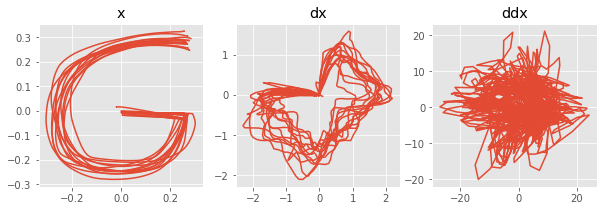

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
for i, title in enumerate(['x', 'dx', 'ddx']): ax[i].set_title(title)

for d in demos_xi:
    ax[0].plot(d[:, 0], d[:, 1])
    ax[1].plot(d[:, 2], d[:, 3])
    ax[2].plot(d[:, 4], d[:, 5])
    [_ax.set_prop_cycle(None) for _ax in ax]

###  Define parameters

In [6]:
# use faster training by splitting whole trajectories and using smaller horizon 
fast = False
if fast:
    raise NotImplementedError("Implementing this in this notebook is let to the reader as an exercise, without loss of generality")

In [7]:
xi_dim = 4  # size of state
u_dim = 2  # size of control command
ensemble_size = batch_size_env = 6
batch_size_p = 5
batch_size = batch_size_env * batch_size_p  # batch_size (number of trajectories to evaluate in parrallel to compute gradient)
horizon = 200  # horizon of the rollouts to evaluate for computing gradients
demos_horizon = 200 # whole horizon of the demonstrations

## Define generator of trajectories 

In [8]:
def from_env_batch_to_batch(m):
    return tf1.batch_gather(m,
        [i for i in range(batch_size_env) for j in range(batch_size_p)])

In [9]:
xi0 = tf1.placeholder(tf.float32, (batch_size_env, xi_dim))  # placeholder for initial state

In [10]:
xi0_batch = from_env_batch_to_batch(xi0)

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [11]:
# we say that the robot is control by inverse dynamics, so we only care about generating
# trajectories with double integretor system
A, B = rl.control.utils.get_canonical(nb_deriv=2, nb_dim=u_dim, dt=dt)  # get linear system (double integrator)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


### Define believed discrete time deterministic system and true system  
$\xi_{t+1} = f(\xi_{t}, u_{t})$

In [13]:
######## NN Non linearity ##########
n_hidden = [10, 10]
noise_dim = 2  # dimension of the input noise
noise_scale = tf1.placeholder(tf.float32, ())   # scale of the input noise (stochasticity of the environment)
pert_scale = tf1.placeholder(1.)   # scale of the perturbation of the NN
act_fct = tf.nn.tanh

nn = rl.nn.MLP(
    n_input=xi_dim + noise_dim, n_output=u_dim, n_hidden=n_hidden,
    batch_size_svi=ensemble_size, act_fct=act_fct)

nn_true = rl.nn.MLP(
    n_input=xi_dim + noise_dim, n_output=u_dim, n_hidden=n_hidden, 
    batch_size_svi=1, act_fct=act_fct)

In [14]:
def perturbation(xi):
    pert = nn.pred(tf.concat([
            tf.reshape(xi, (batch_size_env, batch_size_p, -1)), 
            tf.random.normal((batch_size_env, batch_size_p, noise_dim), 0., noise_scale)
        ], axis=-1))
    return tf.reshape(pert, (batch_size, -1))

def perturbation_true(xi):
    pert = nn_true.pred(tf.concat([
            xi, 
            tf.random.normal((batch_size, noise_dim), 0., noise_scale)
        ], axis=-1))
    return pert

perturbation(tf.ones((batch_size, xi_dim))); perturbation_true(tf.ones((batch_size, xi_dim)));

In [15]:
dynamics_params = [nn.vec_weights]

In [16]:
def f(xi, u, t=0):   # believed system
    """
    xi: [batch_size, xi_dim]
    u: [batch_size, u_dim]
    t : int
    return xi : [batch_size, xi_dim]
    """
    u += pert_scale * perturbation(xi) 
    xi_next = A.matvec(xi) + B.matvec(u)
    
    return xi_next

def f_true(xi, u, t=0):   # true system
    """
    xi: [batch_size, xi_dim]
    u: [batch_size, u_dim]
    t : int
    return xi : [batch_size, xi_dim]
    """
    u += pert_scale * perturbation_true(xi)
    xi_next = A.matvec(xi) + B.matvec(u)

    return xi_next

### Parametrization of policy 

#### Basis functions 

In [17]:
# basis functions to have smooth gains, targets and noise across the time
k_basis = 20
_, h = rl.utils.basis.build_fixed_psi(n_step=demos_horizon, n_dim=xi_dim, n_state=k_basis, scale=0.1)

In [18]:
# create gains as optimal gains with given linear system Ax + Bu,
# quadratic value function S and quadratic cost on u R 
# we can also optimize gains K \in R^{u_dim x xi_dim}, but that way, we facilitate the optimization
R = rl.p.make_cov(u_dim, 10., param='iso', is_prec=True)
S = rl.p.make_cov(xi_dim, [0.02, 0.02, 0.5, 0.5], param='expm', batch_shape=(k_basis, ), is_prec=True)

#### Gains are computed that way: 

$K = (R + B^T S B)^{-1} B^T SA$

The stochastic policy is given as 

$u_t = \mathcal{N} (K_t (\hat{\xi_{t}}-\xi_t), \sigma_t I)$

In [19]:
pi_ks = tf.matmul(
    tf.linalg.inv(R[None] + B.matmul(
            B.matmul(S, adjoint=True), adjoint_arg=True, adjoint=True)),
    tf.linalg.LinearOperatorFullMatrix(B.matmul(S, adjoint=True)).matmul(A._matrix)
)   # gains

pi_target = tf.Variable(tf.random.normal((k_basis, xi_dim), 0., .2))  # target \hat{\xi}
pi_noise = tf.Variable(tf.ones((k_basis, 1)))  # stochasticity of the policy

# expand everything with basis functions
pi_target_t = tf.matmul(h, pi_target)    # expanded target \hat{\xi}
pi_noise_t = tf.matmul(h, tf.math.exp(pi_noise))    # expanded stochasticity of the policy
pi_ks_t = tf.einsum('ai,ijk->ajk', h, pi_ks)    # expanded gains
    
pi_params = [pi_target, pi_noise, R.variable, S.variable]   # variables to train

#### Specify time-dependent policy functions 

In [20]:
activate_pi = tf.Variable(1.)  # to turn of policy and make autonomous

In [21]:
def pi(xi, t):
    """
    xi: [batch_size, xi_dim]
    t : int
    return u : [batch_size, u_dim]
    """
    
    xi_d = pi_target_t[t]
    sigma_u = pi_noise_t[t]
    k = pi_ks_t[t] 
        
    u = tf.linalg.LinearOperatorFullMatrix(k).matvec(xi_d - xi)
    
    return activate_pi * (u + tf.random.normal((batch_size, u_dim), tf.zeros(u_dim), sigma_u))

#### Evaluate samples of whole trajectories 

In [22]:
if fast:
    ts0 = tf1.placeholder(tf.int32, ()) # trajectories can start anywhere
else:
    ts0 = 0 # trajectories always start at beginning

In [23]:
# create samples rollouts with the believed system 
samples_xis, samples_us = rl.control.rollout.make_rollout_samples(
    xi0_batch, f, pi, u_dim=u_dim, T=horizon-1, t0=ts0,
    batch_shape=batch_size)

# create samples rollouts with the true system
samples_xis_true, samples_us_true = rl.control.rollout.make_rollout_samples(
    xi0_batch, f_true, pi, u_dim=u_dim, T=demos_horizon-1, t0=0,
    batch_shape=batch_size)

# concatenate xi and u
samples_xius = tf.concat([samples_xis, samples_us], axis=-1)
samples_xius_true = tf.concat([samples_xis_true, samples_us_true], axis=-1)

In [24]:
if fast: 
    # create full trajectories rollout for display purpose
    samples_xis_f, samples_us_f = rl.control.rollout.make_rollout_samples(
        xi0_batch, f, pi, u_dim=u_dim, T=demos_horizon-1,
        batch_shape=batch_size)

    samples_xius_f = tf.concat([samples_xis_f, samples_us_f], axis=-1)
else:
    samples_xis_f, samples_us_f, samples_xius_f = samples_xis, samples_us, samples_xius

##  Discriminator
Create a discriminator that would distinguish between samples trajectories. 
Instead of using a MLP as proposed, we use a fast, closed form discriminator. It helps for the stability, data-efficiency and efficiency of the training.

We create two approximate distributions $q_{samples}$ and $q_{data}$ and compute the probability of the generated samples trajectories $\tau$ to be in the distribution of data rather than samples as 
$$\frac{p_{data}(\tau)}{p_{data}(\tau) + p_{samples}(\tau)}$$

In [25]:
samples_xius_env = tf.reshape(samples_xius, (batch_size_env, batch_size_p, -1, xi_dim + u_dim))

In [26]:
# a batched Gaussian distribution of trajectory (each timestep independent)
p_data = ds.MultivariateNormalFullCovarianceML(
    tf.Variable(tf.zeros((demos_horizon, xi_dim + u_dim))),
    tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(demos_horizon, ))),
)

# a distribution to encode trajectory executed on the robot and train the dynamics
p_data_true = ds.MultivariateNormalFullCovarianceML(
    tf.Variable(tf.zeros((demos_horizon, xi_dim + u_dim))),
    tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(demos_horizon, ))),
)

if fast:
    # if fast, we extract parameters of full lengths of the demos
    p_data_partial = ds.MultivariateNormalFullCovariance(
        p_data.loc[ts0:ts0+horizon],
        p_data._cov_var[ts0:ts0+horizon]
    )
    
# # the same for samples from our generator where the data is given
# p_samples = ds.MultivariateNormalFullCovarianceML(
#     tf.Variable(tf.zeros((horizon, xi_dim + u_dim))),
#     tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(horizon, ))),
#     data=samples_xius
# )

p_samples = ds.MultivariateNormalFullCovarianceML(
        tf.Variable(tf.zeros((batch_size_env, horizon, xi_dim + u_dim))),
        tf.Variable(tf.eye(xi_dim + u_dim, batch_shape=(batch_size_env, horizon, ))),
    data=tf.transpose(samples_xius_env, (1, 0, 2, 3))
)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


In [27]:
# plotting utilities
p_data_plot = rl.utils.plot.MVNPlot(p_data)
p_samples_plot = rl.utils.plot.MVNPlot(p_samples)

In [28]:
# temperature of discriminator
temp = tf.compat.v1.placeholder(tf.float32, ())

# normalized log probability to be in data or sample distribution
_p_data = p_data_partial if fast else p_data

# computes \frac{p_{data}(\tau)}{p_{data}(\tau) + p_{samples}(\tau)
# temperature of discriminator

p_log_prob = rl.tf.log_normalize([
    temp * tf.reduce_mean(p_data.log_prob(tf.transpose(samples_xius_env, (1, 0, 2, 3))), axis=2), 
    temp * tf.reduce_mean(p_samples.log_prob(tf.transpose(samples_xius_env, (1, 0, 2, 3))), axis=2)
], axis=0) 
# proability to be in data disrtibution 
p_data_prob = tf.exp(p_log_prob[0])

### Optimizer for policy parameters 

In [29]:
# the generator should maximize the probility that its samples are looking like the data
cost_gen = tf.reduce_mean(-p_log_prob[0]) 

### TO SHOW THAT IT CONVERGES TO THE MODE, what we don't want
#cost_gen = -tf.reduce_mean(temp * tf.reduce_mean(p_data.log_prob(samples_phi_xis), axis=1))

In [30]:
# SGD optimizer 
rate_gen = tf1.placeholder(tf.float32, ())
optimizer_gen = tf1.train.AdamOptimizer(rate_gen)
    
train_gen = optimizer_gen.minimize(
    cost_gen, var_list=pi_params
)

### Discriminator for dynamics 

In [31]:
# temperature of discriminator
temp_dyn = tf.compat.v1.placeholder(tf.float32, ())

# computes \frac{p_{data}(\tau)}{p_{data}(\tau) + p_{samples}(\tau)

p_log_prob_dyn = rl.utils.tf.log_normalize([
        temp_dyn * tf.reduce_mean(p_data_true.log_prob(tf.transpose(samples_xius_env, (1, 0, 2, 3))), axis=2), 
        temp_dyn * tf.reduce_mean(p_samples.log_prob(tf.transpose(samples_xius_env, (1, 0, 2, 3))), axis=2)
    ], axis=0)   # stay in log for gradients 

# proability to be in data disrtibution 
p_data_prob_dyn = tf.exp(p_log_prob_dyn[0])

# the generator should maximize the probility that its samples are looking like the data
cost_dyn = tf.reduce_mean(-p_log_prob_dyn[0]) 

### TO SHOW THAT IT CONVERGES TO THE MODE, what we don't want
#cost_gen = -tf.reduce_mean(temp * tf.reduce_mean(p_data.log_prob(samples_phi_xis), axis=1))

### Optimizer for dynamic parameters 

In [32]:
# SGD optimizer 
rate_dyn = tf1.placeholder(tf.float32, ())
optimizer_dyn = tf1.train.AdamOptimizer(rate_dyn)
    
train_dyn = optimizer_dyn.minimize(
    cost_dyn, var_list=dynamics_params
)

In [33]:
init = tf1.global_variables_initializer()

In [34]:
init_policy = tf1.initialize_variables(pi_params)

Instructions for updating:
Use `tf.variables_initializer` instead.


### (Re)loading data and learning samples model 
If you change letter, no need to reexecute everything above

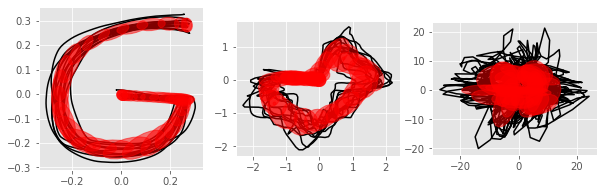

In [35]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
demos_xius = rl.utils.data.load_letter('G', get_x=True, get_dx=True, get_ddx=True, concat=True)

# computing maximum likelihood of Gaussian distribution of trajectories with regularization
p_data.ml(demos_xius, reg_diag=[0.02, 0.02, 0.2, 0.2, 1., 1.])

for i, dim in enumerate([[0, 1], [2, 3], [4, 5]]):
    p_data_plot.plot_gmm(dim=dim, nb=5, ax=ax[i])
    for d in demos_xi:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], 'k')

## Policy optimization
- Run this first
- Notice that the rollouts on the true system do not match the believed one
- Optimize the dynamical parameters (below)
- Rerun policy optimization 
- Iterate but do not run **init** 

In [36]:
j = 0

In [37]:
sess.run(init)

In [38]:
# in some case, one would like to reinitialize the parameters of the policy
sess.run(init_policy)

In [39]:
reg = [0.02, 0.02, 0.2, 0.2, 10., 10.]
feed_dict = {}
p_data.ml(demos_xius, reg_diag=reg)

In [64]:
n_it = 50000

feed_dict = {
        rate_gen : 0.01,  # start with this at the begining 
        rate_gen : 0.004,   # refine solutions
        # rate_gen : 0.001, 
        p_samples.reg_diag:  reg,
        xi0 : get_batch(batch_size)[1]
    }


feed_dict[pert_scale] = 50.
feed_dict[noise_scale] = .2

for i in range(n_it):  
    try:
        display.clear_output(wait=True)
        # generate samples from generator 
        _xi0, _t0= get_batch(batch_size_env, fast=fast) # get xius[0] and take only xdx
        feed_dict[xi0] = _xi0[:, :4]
        if fast:
            feed_dict[ts0] = _t0
        
        ################################
        # put 10 at the beginning for speed and 1 at the end for refinenement and stability
        feed_dict[temp] = 10.
        
        # the Gaussian distribution of samples is computed online by computing 
        # mean and covariances of samples and doing moment matching with previous solution
        # it allows to compute full covariances even with small number of samples
        # alpha specify the weights of the new computation 
        # if alpha is 1. we forget previous solution
        # it is a stochastic gradient descent equivalent of maximum likelihood for Gaussian
        if fast: # always use 1 because trajectories are not aligned between different batch
            feed_dict[p_samples.alpha] = 1. 
        else:
            feed_dict[p_samples.alpha] = .6 if i != 0 else 1.
        ################################
        
        # evaluating samples_xi = 0.03 [s]
        # running ml almost no time
        t0 = time.time()
        _ = sess.run([p_samples.online_ml_op], feed_dict)        
        
        # running ml almost no time
        _ , _c_g, _p_log_prob, _p_data = sess.run([train_gen, cost_gen, p_log_prob, p_data_prob], feed_dict)
        t1 = time.time()
        
        print('dt=%.2f[s]' % (t1- t0))
        print('Cost \t\t: %.3f' % _c_g)
        # print('p_true\t\t: ', _p_data)   # should become close to 0.5 at convergence
        # print('log_p_true\t: ', _p_log_prob[0]) 
        # print(np.mean(pi_ks_t.eval(), axis=0))
            
    except KeyboardInterrupt:
        break

dt=0.17[s]
Cost 		: 18.671


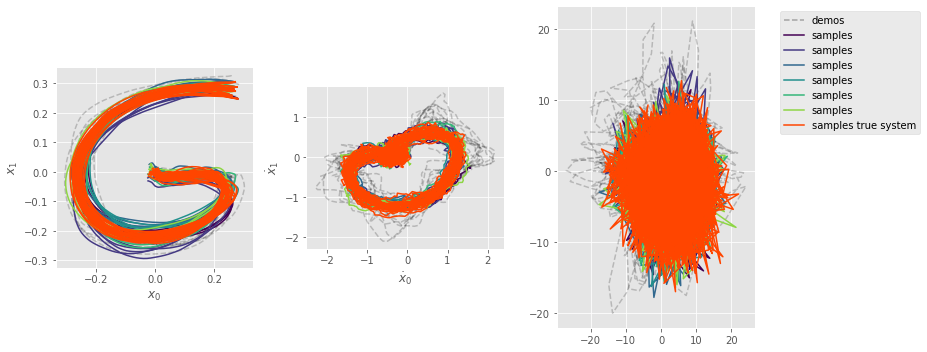

In [65]:
## showing samples of the learned policy on the believed system and the real one
feed_dict[xi0] = get_batch(batch_size_env, fast=False)[0][:, :4]

feed_dict[pert_scale] = 50.
# feed_dict[noise_scale] = .2
# feed_dict[activate_pi] = 1.
# feed_dict[activate_pi] = 0.   # to see if we turn of the policy

_samples_xis, = sess.run([samples_xius_f, ], feed_dict)
_samples_xis_true, = sess.run([samples_xius_true, ], feed_dict)
_xi_d, = sess.run([pi_target_t, ], feed_dict)   

fig, ax = plt.subplots(ncols=3, figsize=(13, 5))

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
ax[0].set_xlabel(r'$x_0$')
ax[0].set_ylabel(r'$x_1$')
ax[1].set_xlabel(r'$\dot{x}_0$')
ax[1].set_ylabel(r'$\dot{x}_1$')

ax[-1].plot([], [], alpha=.3, ls='--', color='k', label='demos')
for j in range(batch_size_env):
    ax[-1].plot([], [], alpha=1., label='samples', color=plt.cm.viridis(
                int(float(j)/batch_size_env * 255)))
ax[-1].plot([], [], alpha=1., label='samples true system', color='orangered')

for i, dim in enumerate([[0, 1], [2, 3], [4, 5]]):
    for d in demos_xi:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], alpha=.2, color='k', ls='--')
    
    for j in range(batch_size_env):
        for d in _samples_xis[j * batch_size_p:(j+1) * batch_size_p]:
            ax[i].plot(d[:, dim[0]], d[:, dim[1]], alpha=1., color=plt.cm.viridis(
                int(float(j)/batch_size_env * 255)))

    for d in _samples_xis_true:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], alpha=1., color='orangered')

ax[-1].legend(bbox_to_anchor=(1.1, 1.))

plt.tight_layout()

### Execute policy on real robot for 15 times (3 x batch_size) 
The samples does not match our expectation as we did not try with the good model. Too bad !!

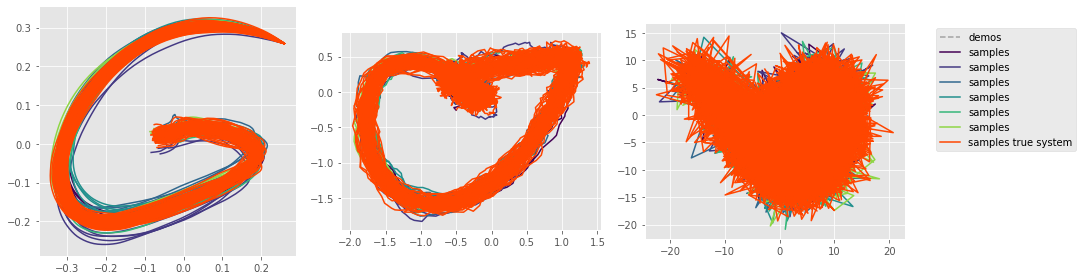

In [61]:
_data_xius_true = []
feed_dict[xi0] = demos_xius[0][0, :xi_dim][None] * np.ones((batch_size_env, 1))

for i in range(3):
    _data_xius_true += [sess.run(samples_xius_true, feed_dict)]

_samples_xis, = sess.run([samples_xius_f, ], feed_dict)

demos_xius_true = np.concatenate(_data_xius_true, axis=0)

fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

# computing maximum likelihood of Gaussian distribution of trajectories with regularization
p_data_true.ml(demos_xius_true, reg_diag=reg)

ax[-1].plot([], [], alpha=.3, ls='--', color='k', label='demos')
for j in range(batch_size_env):
    ax[-1].plot([], [], alpha=1., label='samples', color=plt.cm.viridis(
                int(float(j)/batch_size_env * 255)))
ax[-1].plot([], [], alpha=1., label='samples true system', color='orangered')


for i, dim in enumerate([[0, 1], [2, 3], [4, 5]]):
    ax[i].set_aspect('equal')
    for j in range(batch_size_env):
        for d in _samples_xis[j * batch_size_p:(j+1) * batch_size_p]:
            ax[i].plot(d[:, dim[0]], d[:, dim[1]], alpha=1., color=plt.cm.viridis(
                int(float(j)/batch_size_env * 255)))
    for d in demos_xius_true:
        ax[i].plot(d[:, dim[0]], d[:, dim[1]], 'orangered')    
ax[-1].legend(bbox_to_anchor=(1.1, 1.)); plt.tight_layout()

## Dynamical system optimization 

Now optimizing the dynamical parameters such that the distribution of samples match the one on the robot
After optimizing that, you can start optimizing the policy again

In [60]:
n_it = 50000

feed_dict[rate_dyn] = 0.01  # start with this at the begining 

for i in range(n_it):  
    try:
        display.clear_output(wait=True)
        # generate samples from generator 

        ################################
        # put 10 at the beginning for speed and 1 at the end for refinenement and stability
        feed_dict[temp_dyn] = 10.
        
        # the Gaussian distribution of samples is computed online by computing 
        # mean and covariances of samples and doing moment matching with previous solution
        # it allows to compute full covariances even with small number of samples
        # alpha specify the weights of the new computation 
        # if alpha is 1. we forget previous solution
        # it is a stochastic gradient descent equivalent of maximum likelihood for Gaussian
        if fast: # always use 1 because trajectories are not aligned between different batch
            feed_dict[p_samples.alpha] = 1. 
        else:
            feed_dict[p_samples.alpha] = .6 if i != 0 else 1.
        ################################
        
        # evaluating samples_xi = 0.03 [s]
        # running ml almost no time
        t0 = time.time()
        _ = sess.run([p_samples.online_ml_op], feed_dict)        
        
        # running ml almost no time
        _ , _c_g, _p_log_prob, _p_data = sess.run([
                train_dyn, cost_dyn, p_log_prob_dyn, p_data_prob_dyn],
                                                  feed_dict)
        t1 = time.time()
        
        print('dt=%.2f[s]' % (t1- t0))
        print('Cost \t\t: %.3f' % _c_g)
        
        # print('p_true\t\t: ', _p_data)   # should become close to 0.5 at convergence$
        # print('kv\t: %.2f \tkv_true\t: %.2f' %(_kv, _kv_true))
        # print('log_p_true\t: ', _p_log_prob[0]) 
        # print(np.mean(pi_ks_t.eval(), axis=0))
    except KeyboardInterrupt:
        break

dt=0.21[s]
Cost 		: 4.818
